 #### Time Series Forecasting
 1. https://towardsdatascience.com/time-series-forecasting-with-lstms-using-tensorflow-2-and-keras-in-python-6ceee9c6c651
 2. https://towardsdatascience.com/demand-prediction-with-lstms-using-tensorflow-2-and-keras-in-python-1d1076fc89a0
 3. https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
 
 ** Purpose
 <br>
 making predictions using Recurrent Neural Network
 1. Understand what Time Series are
 2. Learn about Recurrent Neural Networks
 3. Forecast Time Series Data with LSTMs in Keras
 4. Evaluate the model
 
(overall) preprocess Time Series, build a simple LSTM model, train it, and use it to make predictions
 
 
 #### required packages
 sudo apt-get install python3-pandas
 <br>
 sudo apt-get install python3-scipy
 <br>
 sudo apt-get install python3-matplotlib
 <br>
 sudo apt-get install python3-seaborn

Time Series is a collection of data points indexed based on the time they were collected

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'


Time Series is a collection of data points indexed based on the time they were collected
-- deal with data that does have a time component
-- the data is recorded at regular time intervals
-- Stationarity(stationary when the mean and variance remain constant over time), 
   seasonality(phenomenon of variations at specific time-frames), 
   and autocorrelation(correlation between the current value with a copy from a previous time (lag))
   
시계열(時系列, 영어: time series)은 일정 시간 간격으로 배치된 데이터들의 수열
샘플들은 x1, ..., xn 이며, 각각의 샘플들은 특정한 시간 t에서 측정된 데이터들 
예를 들어 x1은 1초에 생성된 정보, x2는 2초 때에 생성된 정보임 
관측치가 시간적 순서를 가진 데이터
변수간의 상관성(correation)이 존재하는 데이터를 다룸
시계열 데이터의 특성을 파악: 경향(trend), 주기(cycle), 계절성(seasonality), 불규칙성(irregular) 

시계열 데이터는 과거의 데이터를 통해서 현재의 움직임 그리고 미래를 예측하는데 다룸 
일반적인 label 데이터는 input과 label 간의 상관관계를 다루는 반면에 시간에 따라 어떻게 움직이는 과거의 자료를 가지고 예측함
과거의 특정 시간(구간)의 데이터를 통해 미래를 예측함 
 

간단하게 아래와 같은 코드를 한 줄 입력하면 5개의 row를  random하게 return 해준다.
df.sample(n=5)
n 대신 frac을 입력하면 전체 row에서 몇%의 데이터를 return할 것인지 정할 수 있다.
df.sample(frac=0.7)
단, frac을 이용하면 전체 데이터의 shuffling도 해볼 수 있다.  시계열 자료이므로   shuffle은 하지 않음 
df.sample(frac=1).reset_index(drop=True)
frac=1을 설정해서 모든 데이터를 반환하고,
reset_index를 해서 기존의 index가 아닌 새로운 indexing을 가능케한다.

In [177]:
df_main = pd.read_csv('T_TEMP_TEST.csv')

print(df_main['Data'].describe())
#df_sample = df_main['Data'][0:1000]
# sampling
df_sample = df_main['Data'].sample(frac=0.002)
DP = len(df_sample) 
print (DP) 
time = np.arange(0, DP, 1)
print (time[:10])

count    262144.000000
mean         23.852871
std           0.753971
min          19.600000
25%          23.300000
50%          23.800000
75%          24.500000
max          27.300000
Name: Data, dtype: float64
524
[0 1 2 3 4 5 6 7 8 9]


In [178]:
df_sample = df_sample.reset_index(drop=True)
df_sample.head()

0    23.2
1    24.8
2    24.6
3    24.8
4    24.8
Name: Data, dtype: float64

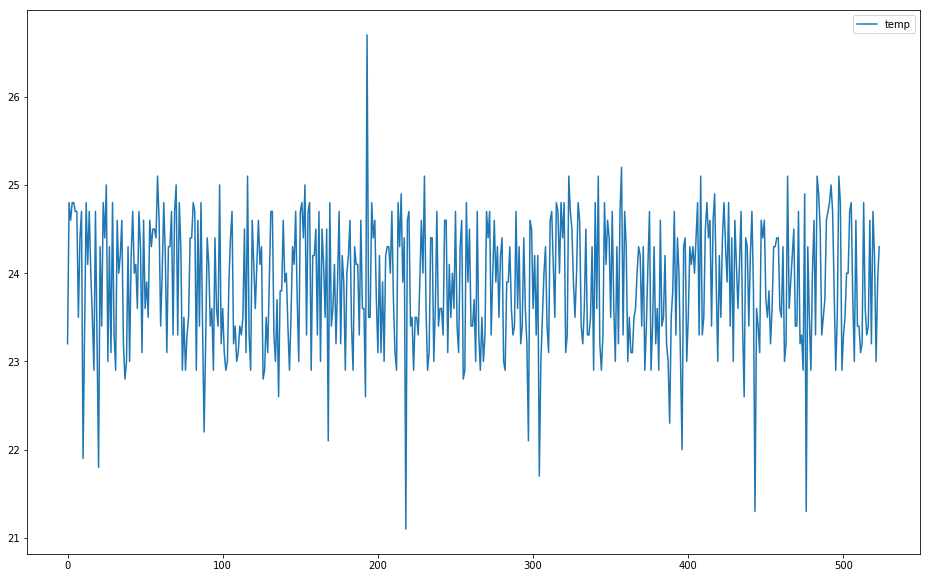

In [179]:
plt.plot(time, df_sample, label='temp');
plt.legend();

In [180]:
df_sample.describe()

count    524.000000
mean      23.870229
std        0.725255
min       21.100000
25%       23.300000
50%       23.900000
75%       24.500000
max       26.700000
Name: Data, dtype: float64

 split it into training and test data:

In [181]:
df = pd.DataFrame(dict(sine=df_sample), index=time, columns=['sine'])

train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

419 105


In [182]:
df.head(10)

,sine
0,23.2
1,24.8
2,24.6
3,24.8
4,24.8
5,24.7
6,24.7
7,23.5
8,24.4
9,24.7


In [183]:
# sudo apt install python3-sklearn
from sklearn.model_selection import train_test_split

#### create_dataset
- We need to predict the value at the current time step by using the history (n time steps from it).
<br>
- It works with univariate (single feature) and multivariate (multiple features) Time Series data.
<br>
- A history of 10 time steps to make our sequences:

In [184]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

#### (samples, time_steps, features)

In [185]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.sine, time_steps)
X_test, y_test = create_dataset(test, test.sine, time_steps)

#print(X_test[0])
#print(y_test[0])
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print(X_train.shape[1], X_train.shape[2]) # input for model 

(409, 10, 1) (409,)
(95, 10, 1) (95,)
10 1


In [186]:
y_test[:10]

array([23. , 24.6, 24.1, 23.6, 24.1, 24.7, 23.4, 22.6, 24.4, 24.3])

#### Modified
 1. https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6

Recurrent neural networks (RNNs) can predict the next value(s) in a sequence or classify it.
Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture[1]


In [187]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dense(units=1))
model.compile(
  loss='mean_squared_error',
  metrics=['accuracy'],
  optimizer=keras.optimizers.Adam(0.001)
)

In [188]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Train on 368 samples, validate on 41 samples
Epoch 1/30
368/368 [==============================] - 11s 29ms/sample - loss: 375.5945 - acc: 0.0000e+00 - val_loss: 242.7358 - val_acc: 0.0000e+00
Epoch 2/30
368/368 [==============================] - 6s 17ms/sample - loss: 177.1827 - acc: 0.0000e+00 - val_loss: 127.4118 - val_acc: 0.0000e+00
Epoch 3/30
368/368 [==============================] - 6s 17ms/sample - loss: 99.7711 - acc: 0.0000e+00 - val_loss: 75.9639 - val_acc: 0.0000e+00
Epoch 4/30
368/368 [==============================] - 7s 19ms/sample - loss: 60.7346 - acc: 0.0000e+00 - val_loss: 46.5576 - val_acc: 0.0000e+00
Epoch 5/30
368/368 [==============================] - 6s 17ms/sample - loss: 36.6668 - acc: 0.0000e+00 - val_loss: 27.5652 - val_acc: 0.0000e+00
Epoch 6/30
368/368 [==============================] - 6s 17ms/sample - loss: 21.3221 - acc: 0.0000e+00 - val_loss: 15.6751 - val_acc: 0.0000e+00
Epoch 7/30
368/368 [==============================] - 6s 16ms/sample - loss: 11.

In [189]:
y_pred = model.predict(X_test)

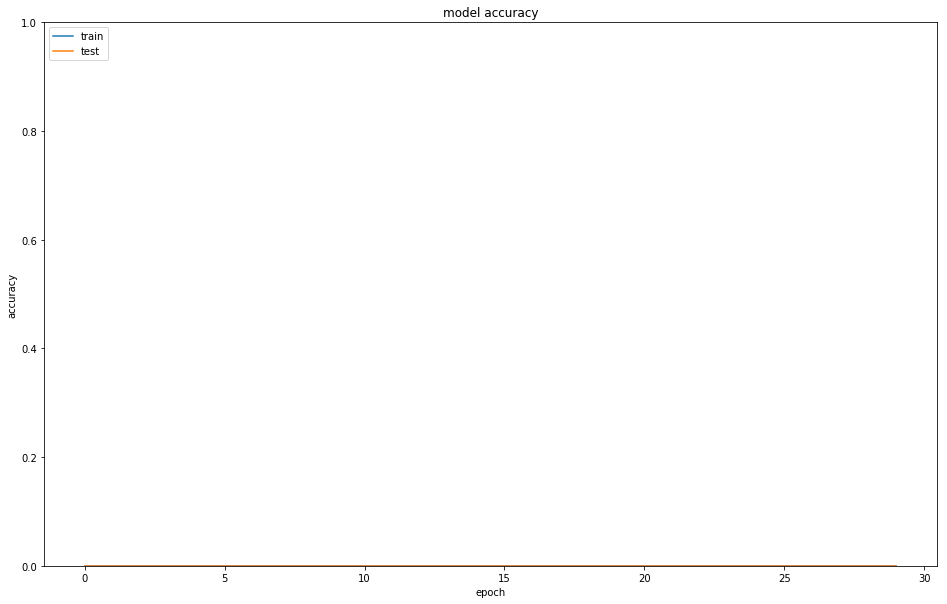

In [155]:
#  acc  is not applied as metrics 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0, 1))
plt.legend(['train', 'test'], loc='upper left');

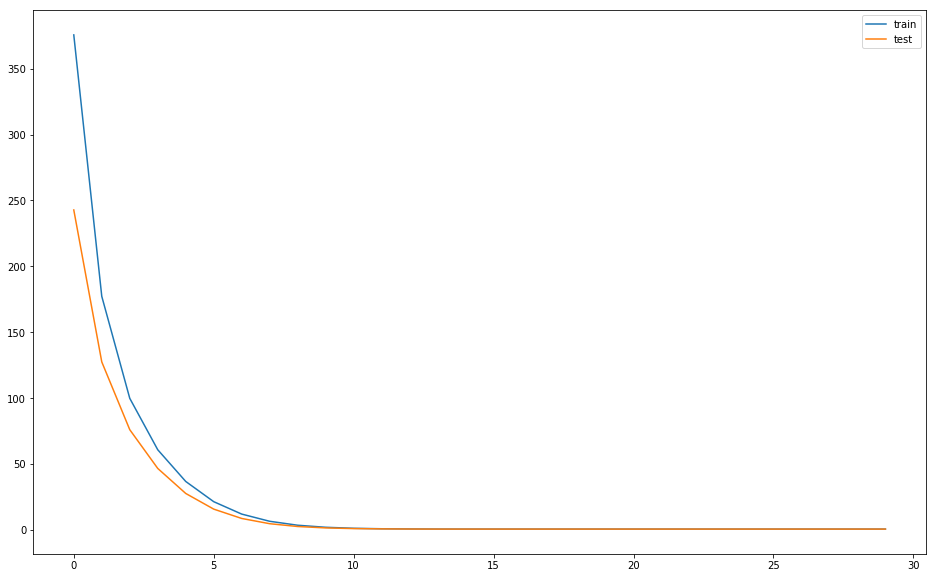

In [190]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

vertically downwards across rows (axis 0)
horizontally across columns (axis 1)


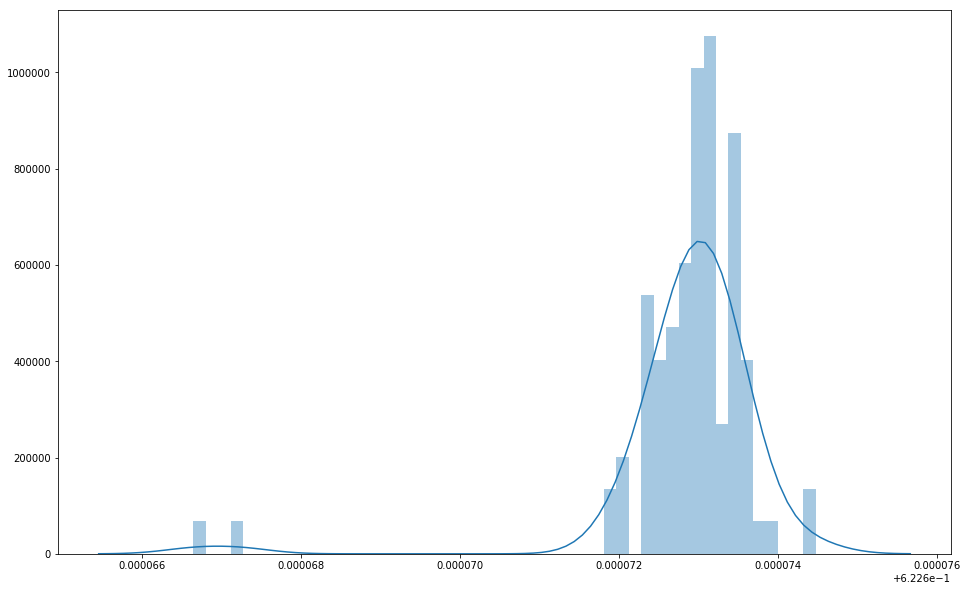

In [192]:
train_mae_loss = np.mean(np.abs(y_pred - y_test), axis=1)
train_mae_loss_zval = np.mean(np.abs(y_pred - y_test),axis=1)/np.std(y_test)
diff = train_mae_loss - train_mae_loss_zval
sns.distplot(train_mae_loss, bins=50, kde=True);
#sns.distplot(train_mae_loss_zval, bins=50, kde=True);
#sns.distplot(np.abs(diff), bins=50, kde=True);

In [193]:
THRESHOLD = 1.4
TIME_STEPS = 10
#test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df = pd.DataFrame()
test_score_df['loss'] = train_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold

In [194]:
test_score_df.head()

,loss,threshold,anomaly
0,0.622672,1.4,False
1,0.622673,1.4,False
2,0.622672,1.4,False
3,0.622673,1.4,False
4,0.622673,1.4,False


In [195]:
test_score_df[test_score_df['anomaly'] == False].sum()

loss          59.153923
threshold    133.000000
anomaly        0.000000
dtype: float64

In [196]:
len(test_score_df)

95

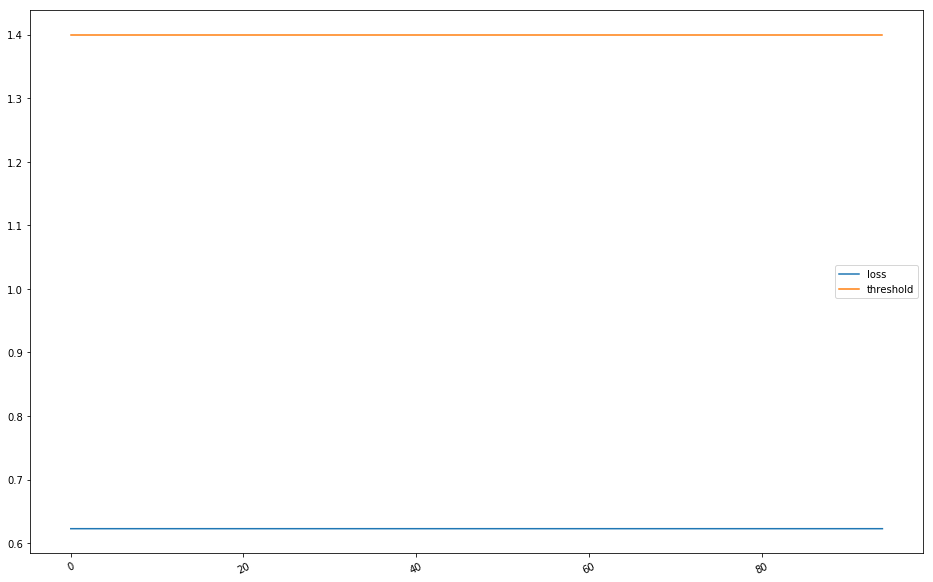

In [197]:
# https://github.com/curiousily/Deep-Learning-For-Hackers/blob/master/14.time-series-anomaly-detection.ipynb
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

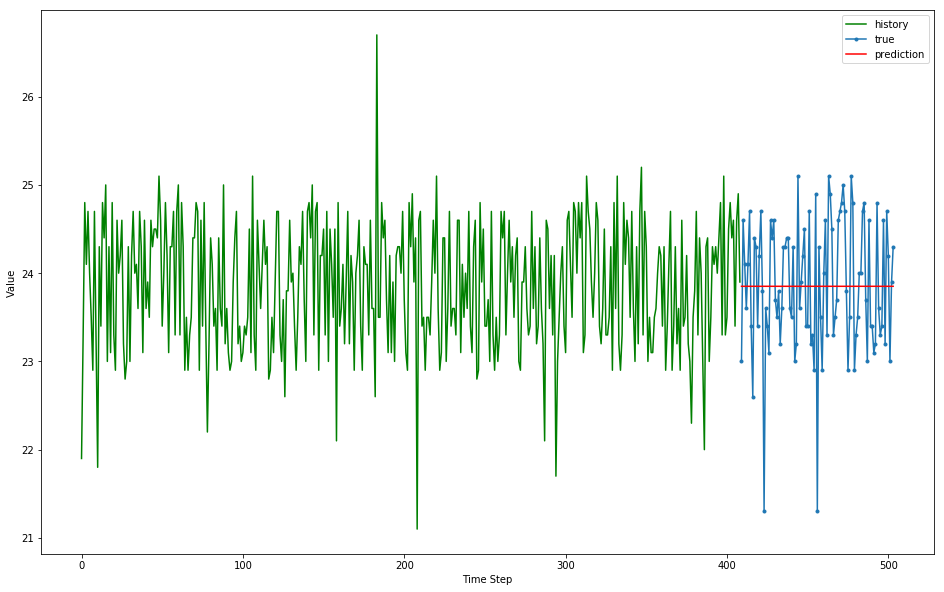

In [198]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

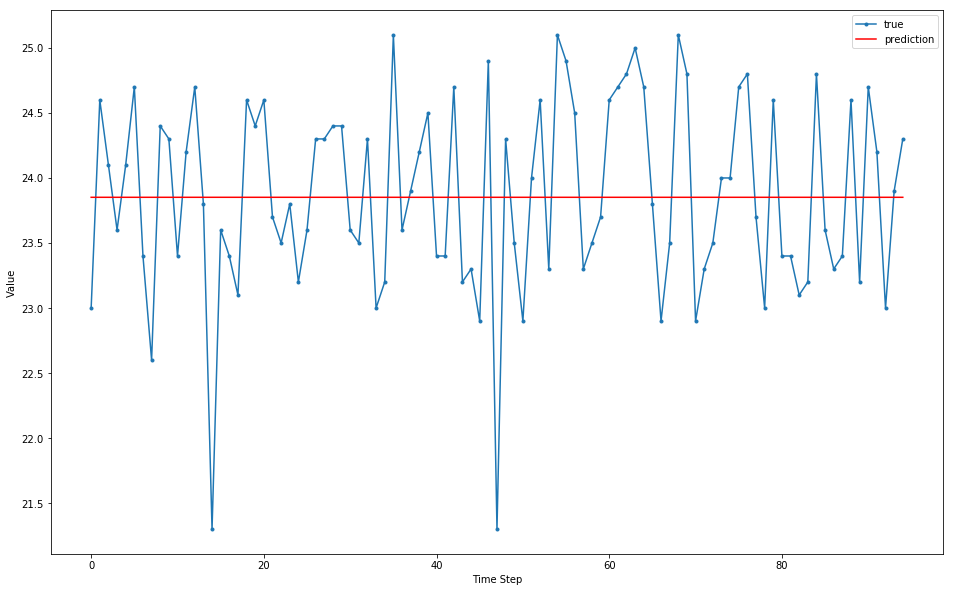

In [206]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [201]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [203]:
y_pred[0]

array([23.851294], dtype=float32)

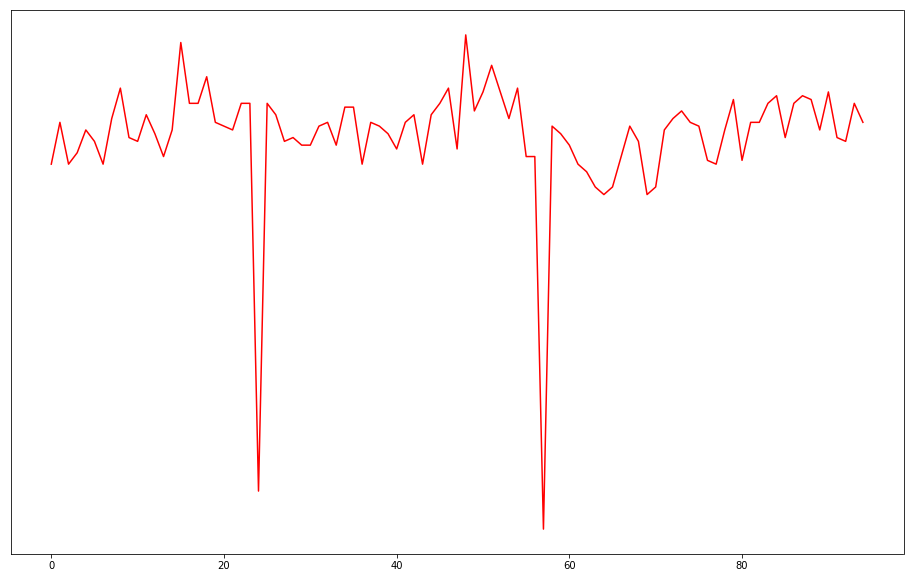

In [218]:
plt.plot(y_pred, 'r', label="prediction")
#plt.plot(y_test, marker='.', label="true")
plt.yscale('log')
plt.show();

df_main.mean         23.852871

df_sample = df_main['Data'].sample(frac=0.005), array([23.859715], dtype=float32)
df_sample = df_main['Data'].sample(frac=0.003), array([23.839983], dtype=float32)
df_sample = df_main['Data'].sample(frac=0.001), array([23.851294]
df = df_main['Data'][0:3000],                   array([24.78595], dtype=float32)
df = df_main['Data'][0:1000],                   array([24.531786], dtype=float32)